In [ ]:
from keras.datasets import mnist
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("y_train.shape",y_train.shape)
print("x_train.shape",x_train.shape)
print("y_test.shape",y_test.shape)
print("x_test.shape",x_test.shape)

y_train.shape (60000,)
x_train.shape (60000, 28, 28)
y_test.shape (10000,)
x_test.shape (10000, 28, 28)


In [ ]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path


class GAN:
    def __init__(self, numbers, epochs=100, batch_size=64, input_layer_size_g=100,
                 hidden_layer_size_g=128, hidden_layer_size_d=128, learning_rate=1e-3,
                 decay_rate=1e-4, image_size=28, display_epochs=5, create_gif=True):
        """
        Implementation of a vanilla GAN using Numpy.
        The Generator and Discriminator are described by multilayer perceptrons.
        Input:
            numbers - # chosen numbers to be generated
            epochs - # #training iterations
            batch_size - # #training examples in each batch
            input_layer_size_g - # #neurons in the input layer of the generator
            hidden_layer_size_g - # #neurons in the hidden layer of the generator
            hidden_layer_size_d - # #neurons in the hidden layer of the discriminator
            learning_rate - to what extent newly acquired info. overrides old info.
            decay_rate - learning rate decay after every epoch
            image_size - # of pixels of training images
            display_epochs - after how many epochs to display intermediary results
            create_gif - if true, a gif of sample images will be generated
        """
        # -------- Initialise hyperparameters --------#
        self.numbers = numbers
        self.epochs = epochs
        self.batch_size = batch_size
        self.nx_g = input_layer_size_g
        self.nh_g = hidden_layer_size_g
        self.nh_d = hidden_layer_size_d
        self.lr = learning_rate
        self.dr = decay_rate
        self.image_size = image_size
        self.display_epochs = display_epochs
        self.create_gif = create_gif

        self.image_dir = Path('./GAN_sample_images')  # new a folder in current directory
        if not self.image_dir.is_dir():
            self.image_dir.mkdir()

        self.filenames = []  # stores filenames of sample images if create_gif is enabled

        # -------- Initialise weights with Xavier method --------#
        # -------- Generator --------#
        self.W0_g = np.random.randn(self.nx_g, self.nh_g) * np.sqrt(2. / self.nx_g)  # 100x128
        self.b0_g = np.zeros((1, self.nh_g))  # 1x100

        self.W1_g = np.random.randn(self.nh_g, self.image_size ** 2) * np.sqrt(2. / self.nh_g)  # 128x784
        self.b1_g = np.zeros((1, self.image_size ** 2))  # 1x784

        # -------- Discriminator --------#
        self.W0_d = np.random.randn(self.image_size ** 2, self.nh_d) * np.sqrt(2. / self.image_size ** 2)  # 784x128
        self.b0_d = np.zeros((1, self.nh_d))  # 1x128

        self.W1_d = np.random.randn(self.nh_d, 1) * np.sqrt(2. / self.nh_d)  # 128x1
        self.b1_d = np.zeros((1, 1))  # 1x1


    def sigmoid(self, x):
        """
        Sigmoid activation function, range [0,1]
        Input:
            x - input training batch (numpy array)
        """
        return 1. / (1. + np.exp(-x))


    def dsigmoid(self, x):
        """
        Derivative of sigmoid activation function
        Input:
            x - input training batch (numpy array)
        """
        y = self.sigmoid(x)
        return y * (1. - y)


    def dtanh(self, x):
        """
        Tanh activation function, range [-1,1]
        Input:
            x - numpy array
        """
        return 1. - np.tanh(x) ** 2


    def lrelu(self, x, alpha=1e-2):
        """
        Leaky ReLU activation function
        Input:
            x - numpy array
            alpha - gradient of mapping function for negative values
            if alpha = 0 then this corresponds to ReLU activation
        """
        return np.maximum(x, x * alpha)


    def dlrelu(self, x, alpha=1e-2):
        """
        Derivative of leaky ReLU activation function
        Input:
            x - numpy array
            alpha - gradient of mapping function for negative values
            if alpha = 0 then this corresponds to the dervative of ReLU
        """
        dx = np.ones_like(x)
        dx[x < 0] = alpha
        return dx


    def forward_generator(self, z):
        """
        Implements forward propagation through the Generator
        Input:
            z - batch of random noise from normal distribution
        Output:
            z1_g - logit output from generator
            a1_g - generated images
        """
        self.z0_g = np.dot(z, self.W0_g) + self.b0_g
        self.a0_g = self.lrelu(self.z0_g, alpha=0)

        self.z1_g = np.dot(self.a0_g, self.W1_g) + self.b1_g
        self.a1_g = np.tanh(self.z1_g)  # check: range -1 to 1 as real images
        return self.z1_g, self.a1_g


    def forward_discriminator(self, x):
        """
        Implements forward propagation through the Discriminator
        Input:
            x - batch of real/fake images
        Output:
            z1_d - logit output from discriminator D(x) / D(G(z))
            a1_d - discriminator's output prediction for real/fake image
        """
        self.z0_d = np.dot(x, self.W0_d) + self.b0_d
        self.a0_d = self.lrelu(self.z0_d)

        self.z1_d = np.dot(self.a0_d, self.W1_d) + self.b1_d
        self.a1_d = self.sigmoid(self.z1_d)  # check: output probability between [0,1]
        return self.z1_d, self.a1_d


    def backward_discriminator(self, x_real, z1_real, a1_real, x_fake, z1_fake, a1_fake):
        """
        Implements backward propagation through the discriminator for fake & real images
        Input:
            x_real - batch of real images from training data
            z1_real - logit output from discriminator D(x)
            a1_real - discriminator's output prediction for real images
            x_fake - batch of generated (fake) images from the generator
            z1_fake - logit output from discriminator D(G(z))
            a1_fake - discriminator's output prediction for fake images
        """
        # -------- Backprop through Discriminator --------#
        # J_D = np.mean(-np.log(a1_real) - np.log(1 - a1_fake))

        # real input gradients -np.log(a1_real)
        da1_real = -1. / (a1_real + 1e-8)  # 64x1

        dz1_real = da1_real * self.dsigmoid(z1_real)  # 64x1
        dW1_real = np.dot(self.a0_d.T, dz1_real)
        db1_real = np.sum(dz1_real, axis=0, keepdims=True)

        da0_real = np.dot(dz1_real, self.W1_d.T)
        dz0_real = da0_real * self.dlrelu(self.z0_d)
        dW0_real = np.dot(x_real.T, dz0_real)
        db0_real = np.sum(dz0_real, axis=0, keepdims=True)

        # fake input gradients -np.log(1 - a1_fake)
        da1_fake = 1. / (1. - a1_fake + 1e-8)

        dz1_fake = da1_fake * self.dsigmoid(z1_fake)
        dW1_fake = np.dot(self.a0_d.T, dz1_fake)
        db1_fake = np.sum(dz1_fake, axis=0, keepdims=True)

        da0_fake = np.dot(dz1_fake, self.W1_d.T)
        dz0_fake = da0_fake * self.dlrelu(self.z0_d, alpha=0)
        dW0_fake = np.dot(x_fake.T, dz0_fake)
        db0_fake = np.sum(dz0_fake, axis=0, keepdims=True)

        # -------- Combine gradients for real & fake images--------#
        dW1 = dW1_real + dW1_fake
        db1 = db1_real + db1_fake

        dW0 = dW0_real + dW0_fake
        db0 = db0_real + db0_fake

        # -------- Update gradients using SGD--------#
        self.W0_d -= self.lr * dW0
        self.b0_d -= self.lr * db0

        self.W1_d -= self.lr * dW1
        self.b1_d -= self.lr * db1


    def backward_generator(self, z, x_fake, z1_fake, a1_fake):
        """
        Implements backward propagation through the Generator
        Input:
            z - random noise batch
            x_fake - batch of generated (fake) images
            z1_fake - logit output from discriminator D(G(z))
            a1_fake - output prediction from discriminator D(G(z))
        """
        # -------- Backprop through Discriminator --------#
        # J_D = np.mean(-np.log(a1_real) - np.log(1 - a1_fake))

        # fake input gradients -np.log(1 - a1_fake)
        da1_d = -1.0 / (a1_fake + 1e-8)  # 64x1

        dz1_d = da1_d * self.dsigmoid(z1_fake)
        da0_d = np.dot(dz1_d, self.W1_d.T)
        dz0_d = da0_d * self.dlrelu(self.z0_d)
        dx_d = np.dot(dz0_d, self.W0_d.T)

        # -------- Backprop through Generator --------#
        # J_G = np.mean(-np.log(1 - a1_fake))
        # fake input gradients -np.log(1 - a1_fake)
        dz1_g = dx_d * self.dtanh(self.z1_g)
        dW1_g = np.dot(self.a0_g.T, dz1_g)
        db1_g = np.sum(dz1_g, axis=0, keepdims=True)

        da0_g = np.dot(dz1_g, self.W1_g.T)
        dz0_g = da0_g * self.dlrelu(self.z0_g, alpha=0)
        dW0_g = np.dot(z.T, dz0_g)
        db0_g = np.sum(dz0_g, axis=0, keepdims=True)

        # -------- Update gradients using SGD --------#
        self.W0_g -= self.lr * dW0_g
        self.b0_g -= self.lr * db0_g

        self.W1_g -= self.lr * dW1_g
        self.b1_g -= self.lr * db1_g


    def preprocess_data(self, x, y):
        """
        Processes the training images and labels:
            1. Only includes samples relevant for training
            i.e. chosen by the user in the numbers list
            2. Removes samples that can't be in a full batch
            3. Scales the images to the range of tanh [-1,1]
            4. Shuffles the data to enable convergence
        Input:
            x - raw training images
            y - raw training labels
        Output:
            x_train - processed training images
            y_train - processed training labels
            num_batches - number of batches
        """
        x_train = []
        y_train = []

        # limit the data to a subset of digits from 0-9
        for i in range(y.shape[0]):
            if y[i] in self.numbers:
                x_train.append(x[i])
                y_train.append(y[i])

        x_train = np.array(x_train)
        y_train = np.array(y_train)

        # limit the data to full batches only
        num_batches = x_train.shape[0] // self.batch_size
        x_train = x_train[: num_batches * self.batch_size]
        y_train = y_train[: num_batches * self.batch_size]

        # flatten the images (_,28,28)->(_, 784)
        x_train = np.reshape(x_train, (x_train.shape[0], -1))

        # normalise the data to the range [-1,1]
        x_train = (x_train.astype(np.float32) - 127.5) / 127.5

        # shuffle the data
        idx = np.random.permutation(len(x_train))
        x_train, y_train = x_train[idx], y_train[idx]
        return x_train, y_train, num_batches

    def sample_images(self, images, epoch, show):
        """
        Generates a grid with sample images from the generator.
        Images are stored in the GAN_sample_images folder in the local directory.
        Input:
            images - generated images (numpy array)
            epoch - current training iteration, used to identify images
            show - if True, the grid of images is displayed
        """
        images = np.reshape(images, (self.batch_size, self.image_size, self.image_size))

        fig = plt.figure(figsize=(4, 4))

        for i in range(16):
            plt.subplot(4, 4, i + 1)
            plt.imshow(images[i] * 127.5 + 127.5, cmap='gray')
            plt.axis('off')

        # saves generated images in the GAN_sample_images folder
        if self.create_gif:
            current_epoch_filename = self.image_dir.joinpath(f"GAN_epoch{epoch}.png")
            self.filenames.append(current_epoch_filename)
            plt.savefig(current_epoch_filename)

        if show == True:
            plt.show()
        else:
            plt.close()


    def generate_gif(self):
        """
        Generates a gif from the exported generated images at each training iteration
        Input:
            filename - name of gif, stored in local directory
        """
        images = []
        for filename in self.filenames:
            images.append(imageio.imread(filename))
        imageio.mimsave("GAN.gif", images)


    def train(self, x, y):
        """
        Main method of the GAN class where training takes place
        Input:
            x - training data, size [no. samples, 28, 28] (numpy array)
            y - training labels, size [no.samples, 1] (numpy array)
        Output:
            J_Ds - Discriminator loss for each pass through the batches (list)
            J_Gs - Generator loss for each pass through the batches(list)
        """
        J_Ds = []  # stores the disciminator losses
        J_Gs = []  # stores the generator losses

        # preprocess input; note that labels aren't needed
        x_train, _, num_batches = self.preprocess_data(x, y)

        for epoch in range(self.epochs):
            for i in range(num_batches):
                # ------- PREPARE INPUT BATCHES & NOISE -------#
                x_real = x_train[i * self.batch_size: (i + 1) * self.batch_size]
                z = np.random.normal(0, 1, size=[self.batch_size, self.nx_g])  # 64x100 --  The size of the random noise being used as input to generator

                # ------- FORWARD PROPAGATION -------#
                z1_g, x_fake = self.forward_generator(z)

                z1_d_real, a1_d_real = self.forward_discriminator(x_real)
                z1_d_fake, a1_d_fake = self.forward_discriminator(x_fake)

                # ------- CROSS ENTROPY LOSS -------#
                # ver1 : max log(D(x)) + log(1 - D(G(z))) (in original paper)
                # ver2 : min -log(D(x)) min log(1 - D(G(z))) (implemented here)
                J_D = np.mean(-np.log(a1_d_real) - np.log(1 - a1_d_fake))
                J_Ds.append(J_D)

                # ver1 : minimize log(1 - D(G(z))) (in original paper)
                # ver2 : maximize log(D(G(z)))
                # ver3 : minimize -log(D(G(z))) (implemented here)
                J_G = np.mean(-np.log(a1_d_fake))
                J_Gs.append(J_G)
                # ------- BACKWARD PROPAGATION -------#
                self.backward_discriminator(x_real, z1_d_real, a1_d_real,
                                            x_fake, z1_d_fake, a1_d_fake)
                self.backward_generator(z, x_fake, z1_d_fake, a1_d_fake)

            if epoch % self.display_epochs == 0:
                print(
                    f"Epoch:{epoch:}|G loss:{J_G:.4f}|D loss:{J_D:.4f}|D(G(z))avg:{np.mean(a1_d_fake):.4f}|D(x)avg:{np.mean(a1_d_real):.4f}|LR:{self.lr:.6f}")
                self.sample_images(x_fake, epoch, show=True)  # display sample images
            else:
                self.sample_images(x_fake, epoch, show=False)

            # reduce learning rate after every epoch
            self.lr = self.lr * (1.0 / (1.0 + self.dr * epoch))

        # generate gif
        if self.create_gif:
            self.generate_gif()
        return J_Ds, J_Gs

Epoch:0|G loss:0.7584|D loss:1.2515|D(G(z))avg:0.4686|D(x)avg:0.5387|LR:0.001000


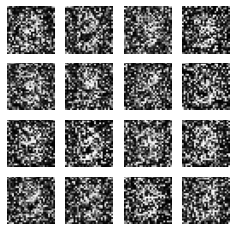

Epoch:5|G loss:0.7852|D loss:1.2002|D(G(z))avg:0.4564|D(x)avg:0.5545|LR:0.000999


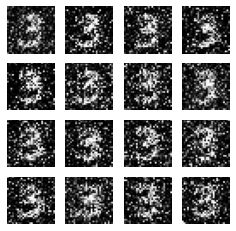

Epoch:10|G loss:0.7204|D loss:1.3257|D(G(z))avg:0.4868|D(x)avg:0.5181|LR:0.000996


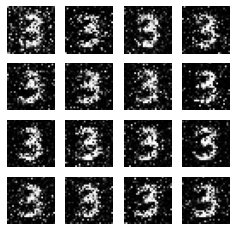

Epoch:15|G loss:0.6930|D loss:1.3831|D(G(z))avg:0.5002|D(x)avg:0.5022|LR:0.000990


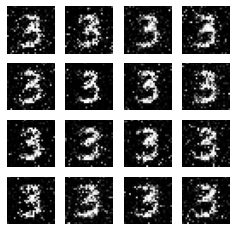

Epoch:20|G loss:0.6775|D loss:1.4151|D(G(z))avg:0.5079|D(x)avg:0.4941|LR:0.000981


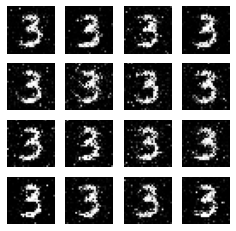

Epoch:25|G loss:0.6709|D loss:1.4305|D(G(z))avg:0.5113|D(x)avg:0.4898|LR:0.000970


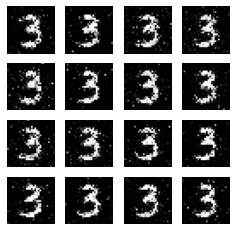

Epoch:30|G loss:0.6651|D loss:1.4428|D(G(z))avg:0.5143|D(x)avg:0.4868|LR:0.000957


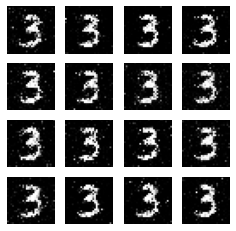

Epoch:35|G loss:0.6628|D loss:1.4487|D(G(z))avg:0.5154|D(x)avg:0.4851|LR:0.000942


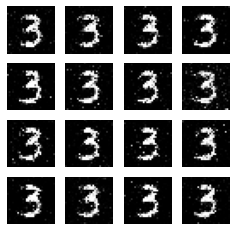

Epoch:40|G loss:0.6610|D loss:1.4529|D(G(z))avg:0.5164|D(x)avg:0.4840|LR:0.000925


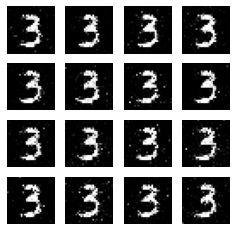

Epoch:45|G loss:0.6596|D loss:1.4549|D(G(z))avg:0.5170|D(x)avg:0.4837|LR:0.000906


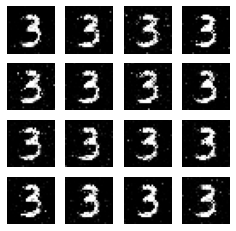

Epoch:50|G loss:0.6606|D loss:1.4546|D(G(z))avg:0.5165|D(x)avg:0.4833|LR:0.000885


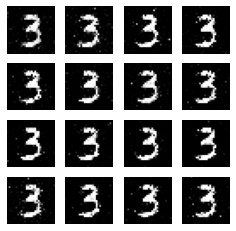

Epoch:55|G loss:0.6610|D loss:1.4518|D(G(z))avg:0.5163|D(x)avg:0.4844|LR:0.000862


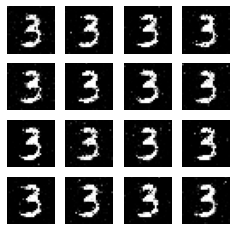

Epoch:60|G loss:0.6632|D loss:1.4466|D(G(z))avg:0.5152|D(x)avg:0.4858|LR:0.000838


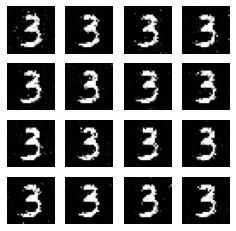

Epoch:65|G loss:0.6665|D loss:1.4407|D(G(z))avg:0.5135|D(x)avg:0.4869|LR:0.000813


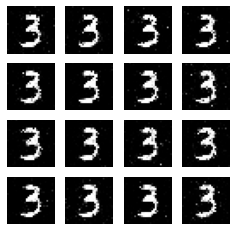

Epoch:70|G loss:0.6695|D loss:1.4338|D(G(z))avg:0.5120|D(x)avg:0.4887|LR:0.000786


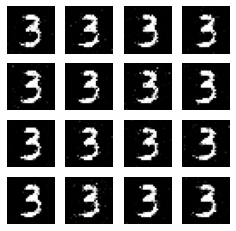

Epoch:75|G loss:0.6744|D loss:1.4239|D(G(z))avg:0.5095|D(x)avg:0.4911|LR:0.000758


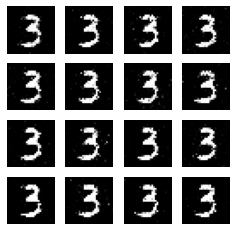

Epoch:80|G loss:0.6798|D loss:1.4135|D(G(z))avg:0.5067|D(x)avg:0.4934|LR:0.000730


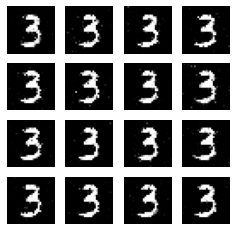

Epoch:85|G loss:0.6852|D loss:1.4022|D(G(z))avg:0.5040|D(x)avg:0.4963|LR:0.000700


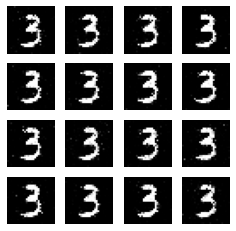

Epoch:90|G loss:0.6907|D loss:1.3903|D(G(z))avg:0.5012|D(x)avg:0.4994|LR:0.000671


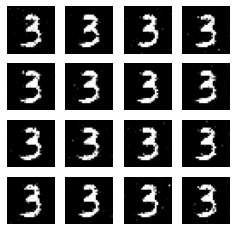

Epoch:95|G loss:0.6970|D loss:1.3778|D(G(z))avg:0.4981|D(x)avg:0.5025|LR:0.000641


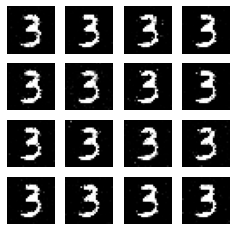

In [ ]:
numbers = [3]

model = GAN(numbers, learning_rate=1e-3, decay_rate=1e-4, epochs=100)
J_Ds, J_Gs = model.train(x_train, y_train)